In [5]:
#basic imports ✌

import matplotlib.pyplot as plt
import os
import random
import numpy as np
import math, random
import tensorflow as tf
#os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras as ks
import soundfile as sf
import sounddevice as sd
import python_speech_features

%matplotlib inline
np.random.seed(0)

In [6]:
#Finding speech sample 🤷‍🤷‍🤷‍
class speech:
    
    def choose_random(self):
        path = r"C:\Users\Darius\Desktop\sound samples\training data for RNN\LibriSpeech\train-clean-100"
        for i in range (0,3):
            files = os.listdir(path)
            index = random.randrange(0, len(files))
            while  files[index].endswith('.txt'):
                #index = index + 1
                index = random.randrange(0, len(files))
            path  = os.path.join(path, files[index])
        file_path = path
        self.sample, fs2 = sf.read(file_path)
        
        self.size = len(self.sample)
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)

    def show_sample(self):
        print(file_path)
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [7]:
#Finding noise sample 🎉🎉🎉🎉🎷🎸🎶🎵🎵
class noise:
    def __init__(self,size):
        self.size = size
    
    def choose_random(self):
        path = r"C:\Users\Darius\Desktop\sound samples\training data for RNN\rnnoise_contributions"
        files = os.listdir(path)
        index = random.randrange(0, len(files))
        if  files[index].endswith('.txt'):
            index = index -1
        file_path = os.path.join(path, files[index])
        self.sample, fs = sf.read(file_path, channels=2, samplerate=24100,format='RAW', subtype='PCM_16')

        i=0
        while i!=1:
            random_sequence = random.randrange(0,len(self.sample))
            if random_sequence + self.size < len(self.sample):
                i=1
        self.sample = self.sample[random_sequence:]
        self.sample = self.sample[:self.size ,:1]
        
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)
        
    def show_sample():
        print(file_path)
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [8]:
#making input sample  🎵🎵🤷‍🤷‍
class combined_samples:
    def __init__(self,speech_sample,noise_sample):
        self.speech_sample = speech_sample
        self.noise_sample  = noise_sample
    
    def combine_samples(self):
        self.sample = [len(self.speech_sample)] * 0
        self.sample = np.empty([len(self.speech_sample)])

        for i in range(len(self.speech_sample)):
            self.sample[i] = self.speech_sample[i] + self.noise_sample[i]
        
        self.size = len(self.sample)
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)
        
    def show_sample(self):
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [9]:
# Training Data
class training_data:
    def get_data(self):
        self.speechD = speech()
        self.speechD.choose_random()
        
        self.noiseD = noise(self.speechD.size)
        self.noiseD.choose_random()
        
        self.combined = combined_samples(self.speechD.sample , self.noiseD.sample)
        self.combined.combine_samples()
        
        self.input = self.combined.nfcc
        self.output= self.speechD.nfcc

In [10]:
d = training_data()
d.get_data()

In [8]:
#Creating The GRU NN
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Activation, GRU, Flatten, Embedding

input_dim = 24
max_dim = 2000

model = Sequential()

model.add(GRU(input_dim,input_shape=(None,input_dim),activation='tanh',return_sequences=True))

model.add(Dropout(0.15))

model.add(GRU(input_dim,input_shape=(None,input_dim),activation='tanh', return_sequences=True))
model.add(Dropout(0.15))

model.add(Dense(units=input_dim))
model.add(Activation("linear"))


model.build()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [9]:
model.summary()

logs_dir= './event_logs_new'
tbCallBack=ks.callbacks.TensorBoard(log_dir='./event_logs_new', histogram_freq=0,
                            write_graph=True, write_images=True)

from keras.utils.vis_utils import plot_model
os.environ["PATH"] += os.pathsep + r"\\Users\\Darius\\Desktop\\RNN stuff\\graphviz\\"
import pydot_ng as pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 24)          3528      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 24)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 24)          3528      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 24)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 24)          600       
_________________________________________________________________
activation_1 (Activation)    (None, None, 24)          0         
Total params: 7,656
Trainable params: 7,656
Non-trainable params: 0
_________________________________________________________________


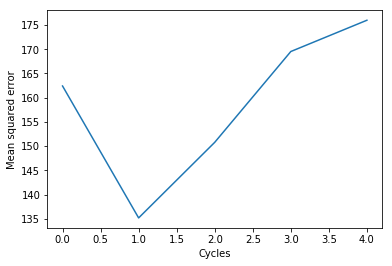

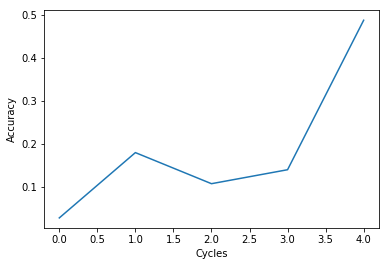

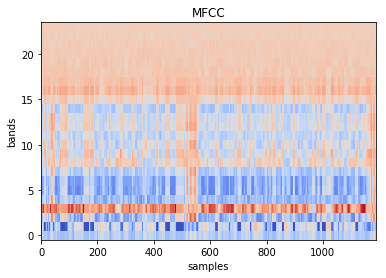

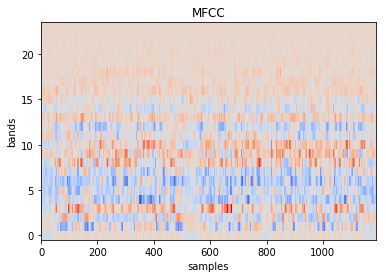

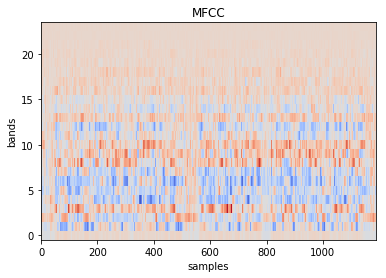

In [17]:
#predictions
pred= model.predict(np.expand_dims(d.input,axis=0))
pred= np.squeeze(pred, axis=0)
from matplotlib import cm
#Plotting the MFCC diagrams
fig,ax=plt.subplots()
mfcc_data=np.swapaxes(pred,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.xlabel('samples')
plt.ylabel('bands')
plt.show()


fig,ax=plt.subplots()
mfcc_data=np.swapaxes(d.output,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.xlabel('samples')
plt.ylabel('bands')
plt.show()


fig,ax=plt.subplots()
mfcc_data=np.swapaxes(d.input,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.xlabel('samples')
plt.ylabel('bands')
plt.show()

In [23]:
model.save('my_model.h5')

In [25]:
score= model.evaluate(np.expand_dims(d.input,axis=0),np.expand_dims(d.output,axis=0))

print(score)

1/1 [==============================] - 1s 584ms/step
[101.06051635742188, 0.17313432693481445]


In [28]:
Prediction=model.predict(np.expand_dims(d.input,axis=0))
print(Prediction)
Prediction.shape

[[[-0.95786023 -3.8316019   1.0448074  ... -0.04131719  0.00819611
   -0.04993513]
  [-0.87169814 -5.0794463   1.9356959  ... -0.03893114  0.04094901
   -0.0521542 ]
  [-0.766798   -5.4925933   2.158474   ... -0.02716053  0.06006389
   -0.0509106 ]
  ...
  [-0.9424772  -3.3716023   3.120957   ... -0.19316113 -0.07078583
   -0.07117876]
  [-1.0127501  -3.704049    2.609818   ... -0.23487997 -0.02657641
   -0.09712419]
  [-0.54889596 -3.9876292   3.2062387  ... -0.17034513  0.02100711
   -0.08951511]]]


(1, 1340, 24)

In [13]:
#model.fit(asta,asta2,callbacks=[tbCallBack],epochs=5,batch_size=20,validation_data=(valid1,valid2))
model.fit(asta,asta2,callbacks=[TrainValTensorBoard(write_graph=False)],epochs=5,batch_size=20,validation_data=(valid1,valid2))

Train on 1000 samples, validate on 400 samples
Epoch 1/5
1000/1000 [==============================] - 306s 306ms/step - loss: 79.7176 - acc: 0.0532 - val_loss: 77.7198 - val_acc: 0.0662
Epoch 2/5
1000/1000 [==============================] - 296s 296ms/step - loss: 74.6783 - acc: 0.0717 - val_loss: 73.6108 - val_acc: 0.1070
Epoch 3/5
1000/1000 [==============================] - 295s 295ms/step - loss: 71.3613 - acc: 0.1082 - val_loss: 70.8165 - val_acc: 0.1190
Epoch 4/5
1000/1000 [==============================] - 312s 312ms/step - loss: 68.9028 - acc: 0.1180 - val_loss: 68.5672 - val_acc: 0.1229
Epoch 5/5
1000/1000 [==============================] - 308s 308ms/step - loss: 66.8678 - acc: 0.1248 - val_loss: 66.6464 - val_acc: 0.1314


In [9]:
def DataGenerator(batch_size):
    batch_inputs = np.zeros(shape=(batch_size,2000,24))
    batch_outputs= np.zeros(shape=(batch_size,2000,24))
    while True:
        for i in range(batch_size):
            d.get_data()
            for j in range(len(d.input)):
                for h in range(len(d.input[j])):
                    batch_inputs[i][j][h] = d.input[j][h]
                    batch_outputs[i][j][h]= d.output[j][h]
        yield batch_inputs , batch_outputs

In [12]:
model.fit_generator(DataGenerator(20),callbacks=[TrainValTensorBoard(write_graph=False)],verbose=2,epochs=5,steps_per_epoch=50,validation_data=(valid1,valid2))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 934s - loss: 99.4765 - acc: 0.0724 - val_loss: 77.5870 - val_acc: 0.0806
Epoch 2/5
 - 783s - loss: 96.3490 - acc: 0.1136 - val_loss: 73.4063 - val_acc: 0.1139
Epoch 3/5
 - 669s - loss: 92.8606 - acc: 0.1479 - val_loss: 70.5695 - val_acc: 0.1194
Epoch 4/5
 - 651s - loss: 89.6735 - acc: 0.1565 - val_loss: 68.2554 - val_acc: 0.1237
Epoch 5/5
 - 645s - loss: 87.9542 - acc: 0.1664 - val_loss: 66.2663 - val_acc: 0.1336


In [ ]:
nrSamples=3000
asta1=np.zeros(shape=(nrSamples,2000,24))
asta2=np.zeros(shape=(nrSamples,2000,24))
for i in range(nrSamples):
    for j in range(len(d.input)):
        for h in range(len(d.input[j])):
            asta1[i][j][h]=d.input[j][h]
            asta2[i][j][h]=d.output[j][h]
    if(i%100==0):
        print(i)
    d.get_data()
            

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [22]:
nrSamples=1200
valid1=np.zeros(shape=(nrSamples,2000,24))
valid2=np.zeros(shape=(nrSamples,2000,24))
for i in range(nrSamples):
    for j in range(len(d.input)):
        for h in range(len(d.input[j])):
            valid1[i][j][h]=d.input[j][h]
            valid2[i][j][h]=d.output[j][h]
    if(i%100==0):
        print(i)
    d.get_data()
            

0
100
200
300


In [24]:
np.save('asta.npy',asta)
np.save('asta2.npy',asta2)
np.save('valid1.npy',valid1)
np.save('valid2.npy',valid2)

In [10]:
nrSamples=1000
asta=np.zeros(shape=(nrSamples,2000,24))
asta2=np.zeros(shape=(nrSamples,2000,24))

nrSamples2=400
valid1=np.zeros(shape=(nrSamples2,2000,24))
valid2=np.zeros(shape=(nrSamples2,2000,24))

asta=np.load('asta.npy')
asta2=np.load('asta2.npy')
valid1=np.load('valid1.npy')
valid2=np.load('valid2.npy')

In [11]:
from keras.callbacks import TensorBoard

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./event_logs_new', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [ ]:
#model.fit(asta,asta2,callbacks=[TrainValTensorBoard(write_graph=False)],epochs=30,batch_size=20,validation_data=(valid1,valid2))

#import datetime
#datetime.datetime.now()

model.fit_generator(DataGenerator(20),callbacks=[TrainValTensorBoard(write_graph=False)],verbose=1,epochs=30,steps_per_epoch=50,validation_data=(valid1,valid2))



Epoch 1/30
50/50 [==============================] - 690s 14s/step - loss: 98.7323 - acc: 0.0642 - val_loss: 77.1183 - val_acc: 0.0749
Epoch 2/30
50/50 [==============================] - 699s 14s/step - loss: 95.2981 - acc: 0.1074 - val_loss: 73.1465 - val_acc: 0.1123
Epoch 3/30
50/50 [==============================] - 631s 13s/step - loss: 94.0842 - acc: 0.1506 - val_loss: 70.3406 - val_acc: 0.1198
Epoch 4/30
50/50 [==============================] - 626s 13s/step - loss: 88.8788 - acc: 0.1570 - val_loss: 68.0968 - val_acc: 0.1263
Epoch 5/30
50/50 [==============================] - 620s 12s/step - loss: 87.8087 - acc: 0.1687 - val_loss: 66.1306 - val_acc: 0.1345
Epoch 6/30
50/50 [==============================] - 632s 13s/step - loss: 85.9201 - acc: 0.1797 - val_loss: 64.4203 - val_acc: 0.1422
Epoch 7/30
50/50 [==============================] - 615s 12s/step - loss: 83.5375 - acc: 0.1914 - val_loss: 62.8384 - val_acc: 0.1545
Epoch 8/30
50/50 [==============================] - 614s 12s/s